In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import copy
import pylab
sns.set()

# setup jupyter notebook 
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [29]:
# data loading function 

def load_yelp():
    # Load a csv of floats:
    X = np.genfromtxt("upvote_data.csv", delimiter=",")
    # Load a text file of integers:
    y = np.loadtxt("upvote_labels.txt", dtype=np.int)
    # Load a text file of strings:
    featureNames = open("upvote_features.txt").read().splitlines()

    return X,y,featureNames

# data splitting function

def split(data,labels):
    n_train = 4000
    n_valid = 1000
    n_test = 1000
    
    train_d = data[0:n_train,:]
    train_l = labels[0:n_train]
    
    # get rid of outliers
    ind_outlier = np.argmax(train_l)
    #ind_outlier = np.argmax(np.max(np.abs(train_d),axis=1))
    #ind_outlier = np.argpartition(np.max(np.abs(train_d),axis=1),-10)[-10:]

    mask_good = np.ones((np.shape(train_d)[0],),dtype=bool)
    mask_good[ind_outlier] = False
    train_d = train_d[mask_good,:]
    train_l = train_l[mask_good]

    # demean!
    demean= True
    if demean:
        train_d_mean = train_d.mean(axis=0)
        train_l_mean = train_l.mean(axis=0)

        train_d = train_d - train_d_mean[np.newaxis, :]
        train_l = train_l - train_l_mean

    valid_d = data[n_train:n_train+n_valid,:]
    valid_l = labels[n_train:n_train+n_valid]
    
    test_d = data[n_valid::,:]
    test_l = labels[n_valid::]
    
    if demean:

        valid_d = valid_d - train_d_mean[np.newaxis, :]
        valid_l = valid_l - train_l_mean

        test_d = test_d - train_d_mean[np.newaxis, :]
        test_l = test_l - train_l_mean
    
    return train_d,valid_d,test_d,train_l,valid_l,test_l

### lasso max function 

def lambda_max_func(x,y):
    k = np.shape(x)[1]
    n = np.shape(x)[0]
    lambda_vec = []
    sum_y = (1/n)*np.sum(y[:])
    k_range = np.arange(k)
    lambda_max = np.max([2*np.abs(np.dot(x[:,k_ind].T,(y-sum_y))) for k_ind in k_range])
    return lambda_max

# lasso calculation function called by loop 

def lasso_CD(x,y,lambda_val,w_init):
    ### initialize conditions 
    delta = 1e-3
    n = np.shape(x)[0]
    d = np.shape(x)[1]

    stop_cond = 100
    w = w_init
    a = np.zeros((d,))
    c = np.zeros((d,))
    stop_cond_vec = []
    w_old = np.zeros((d,))
    
    # loop while the weights are still changing above a threshold
    while(stop_cond>delta):
        diff_y_x = y - np.dot(x,w)
        w_0 = (1/n)*np.sum(diff_y_x)

        for k in np.arange(d):
            a[k] = 2*np.dot(x[:,k].T,x[:,k])

            # subtract version
            
            diff_y_x_w0 = y - w_0 - np.dot(x,w) + np.dot(x[:,k],w[k])
            
            # bool version
#             mask = np.ones(d,dtype=bool)
#             mask[k] = 0
#             x_temp = x[:,mask]
#             w_temp = w[mask]

#             diff_y_x_w0 = y - w_0 - np.dot(x_temp,w_temp)
            
            #calculate c 
            c[k] = 2*np.dot(x[:,k].T,diff_y_x_w0)
            
            # calculate weights
            if c[k] < - lambda_val:
                w[k] = ((c[k]+lambda_val))/a[k]
            elif (-lambda_val < c[k] < lambda_val):
                w[k] = 0
            elif c[k] > lambda_val:
                w[k] = ((c[k]-lambda_val))/a[k]
        
        weight_diff = w - w_old
        w_old = np.array(w)
        
        # use maximum of weight difference 
        #stop_cond = np.max(weight_diff)
        
        # use absolute value of mean weight difference 
        stop_cond = np.abs(np.mean(weight_diff))
        print('value of lasso run {}'.format(stop_cond))    
    return w

# master function which calls the lasso max and lasso_CD functions 
def lasso_loop(x_t,y_t,x_v,y_v):
    
    # initialize variables 
    w_vec = []
    num_non_zero_vec = []
    lambda_val = lambda_max_func(x_t,y_t)
    lambda_vec = []
    valid_error_vec=[]
    train_error_vec = []
    valid_error_diff = 100
    valid_error_old = 100
    #valid_error_delta = 1e-2
    
    # stop condition 
    valid_error_delta = 1e-3
    
    # ratio to decrease lambda by 
    lambda_ratio = 5/6

    # random initialization for kaggle 
    w_init = np.random.random(np.shape(x_t)[1])
    
    while (lambda_val>5e-1):

    #while (valid_error_diff>valid_error_delta):
        print('the value of lambda is {}'.format(lambda_val))
        w = lasso_CD(x_t,y_t,lambda_val,w_init)
        
        # total non zero entries 
        num_non_zero = sum((np.abs(x)>0 for x in w))
        
        w_vec.append(w)

        w_init = np.array(w)
        
        # train and validation error 
        train_error = error_calc(x_t,y_t,w)
        valid_error = error_calc(x_v,y_v,w)
        
        num_non_zero_vec.append(num_non_zero)
        lambda_vec.append(lambda_val)
        lambda_val = lambda_val*lambda_ratio

        train_error_vec.append(train_error)
        valid_error_vec.append(valid_error)
        valid_error_diff = np.abs(valid_error - valid_error_old)
        valid_error_old = copy.copy(valid_error)
        print('The train error was {}'.format(train_error))

        print('The validation error was {}'.format(valid_error))
        print('The validation error difference was {}'.format(valid_error_diff))
    
    return w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec

# calculate the mean square error 
def error_calc(x,y,w):
    n = np.shape(y)[0]
    error = (1/n)*np.sum((y-np.dot(x,w))**2)
    return error

# plot both error, and number of non zero entries 
def plot_valid_train(train_error_vec,valid_error_vec,num_non_zero_vec,lambda_vec):
   
    ax1= plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(lambda_vec,train_error_vec,label='training error')
    plt.plot(lambda_vec,valid_error_vec,label='validation error')
    plt.xlabel(r'$ \lambda $')
    plt.title('Training and Validation error for' +'\n' +'various values of Lambda ')
    plt.ylabel('error')
    plt.legend()
    plt.savefig('hw2_valid_train_error_kaggle_noYmean_noOutlier.png')

    ax2 = plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(lambda_vec,num_non_zero_vec)
    plt.xlabel(r'$ \lambda $')
    plt.ylabel('Number of non zero entries')
    plt.title('Number of non zero entries for ' + '\n' + 'various values of lambda')
    plt.savefig('hw2_nonzero_kaggle_noYmean_noOutlier.png')

# plot the lasso weights , and weight differences 
def plot_lasso(w,stop_cond_vec,w_star):
    plt.figure()
    ax1 = sns.distplot(w, rug=True,hist=True,bins=100, kde=False, rug_kws={"color": "g"},hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})

    plt.figure()
    ax3 = plt.plot(np.arange(len(stop_cond_vec)),stop_cond_vec)


### part a

In [30]:
# load data
X,y,featureNames = load_yelp()

In [31]:
# split data
train_d,valid_d,test_d,train_l,valid_l,test_l = split(X,y)

In [32]:

# # get rid of outliers
# #ind_outlier = np.argmax(np.max(np.abs(train_d),axis=1))

# outliers_noOutlier = (np.max(np.abs(train_d),axis=1))


# print(np.shape(outliers_noOutlier))
# plt.figure()
# plt.hist(outliers_noOutlier)

# plt.figure()
# plt.hist(train_l)


In [33]:
# np.shape(train_d)
# outliers = (np.max(np.abs(train_d),axis=0))
# plt.hist(outliers)
# outliers[622]

# np.shape(train_d)
# ind_outlier = np.argmax(np.max(np.abs(train_d),axis=1))
# np.shape(np.max(np.abs(train_d),axis=1))
# mask_good = np.ones((np.shape(train_d)[0],),dtype=bool)
# mask_good[ind_outlier] = False
# print('mask shape is ' + str(np.shape(mask_good)))
# train_d_noOutlier = np.array(train_d[mask_good,:])
# train_l_noOutlier = np.array(train_l[mask_good])
# outliers_noOutlier = (np.max(np.abs(train_d_noOutlier),axis=1))
# np.shape(outliers_noOutlier)
# plt.figure()
# plt.hist(outliers_noOutlier)


In [34]:
# np.shape(train_d)
# #ind_outlier = np.argmax(np.max(np.abs(train_d),axis=1))
# ind_outlier = np.argpartition(np.max(np.abs(train_d),axis=1),-10)[-10:]
# mask_good = np.ones((np.shape(train_d)[0],),dtype=bool)
# mask_good[ind_outlier] = False
# np.shape(mask_good)
# train_d_noOut = train_d[mask_good,:]
# train_l_noOut = train_l[mask_good]
# outliers_noOutlier = (np.max(np.abs(train_d_noOut),axis=1))
# np.shape(outliers_noOutlier)
# plt.figure()
# plt.hist(outliers_noOutlier)


In [35]:
w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec = lasso_loop(train_d,train_l,valid_d,valid_l)

#w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec = lasso_loop(train_d_noOut,train_l_noOut,valid_d,valid_l)

the value of lambda is 146.95618024266457
value of lasso run 0.11200329484822631
value of lasso run 0.11352473805755921
value of lasso run 0.001521443209332894
value of lasso run 0.0
The train error was 5.059752685108012
The validation error was 5.272065269380611
The validation error difference was 94.7279347306194
the value of lambda is 122.46348353555382
value of lasso run 0.01909368614785705
value of lasso run 0.00046482030110160053
The train error was 4.43472625424818
The validation error was 4.470917317743059
The validation error difference was 0.8011479516375521
the value of lambda is 102.05290294629485
value of lasso run 0.0346538080193998
value of lasso run 0.0005093674295814287
The train error was 4.002178180684882
The validation error was 3.914204738086881
The validation error difference was 0.5567125796561774
the value of lambda is 85.04408578857904
value of lasso run 0.047614578485209454
value of lasso run 0.0005484827853275922
The train error was 3.702882881792038
The vali

value of lasso run 0.09558546677671877
value of lasso run 0.00027893439652424703
The train error was 2.3509035822473443
The validation error was 2.4975189292807083
The validation error difference was 0.012982999057668199


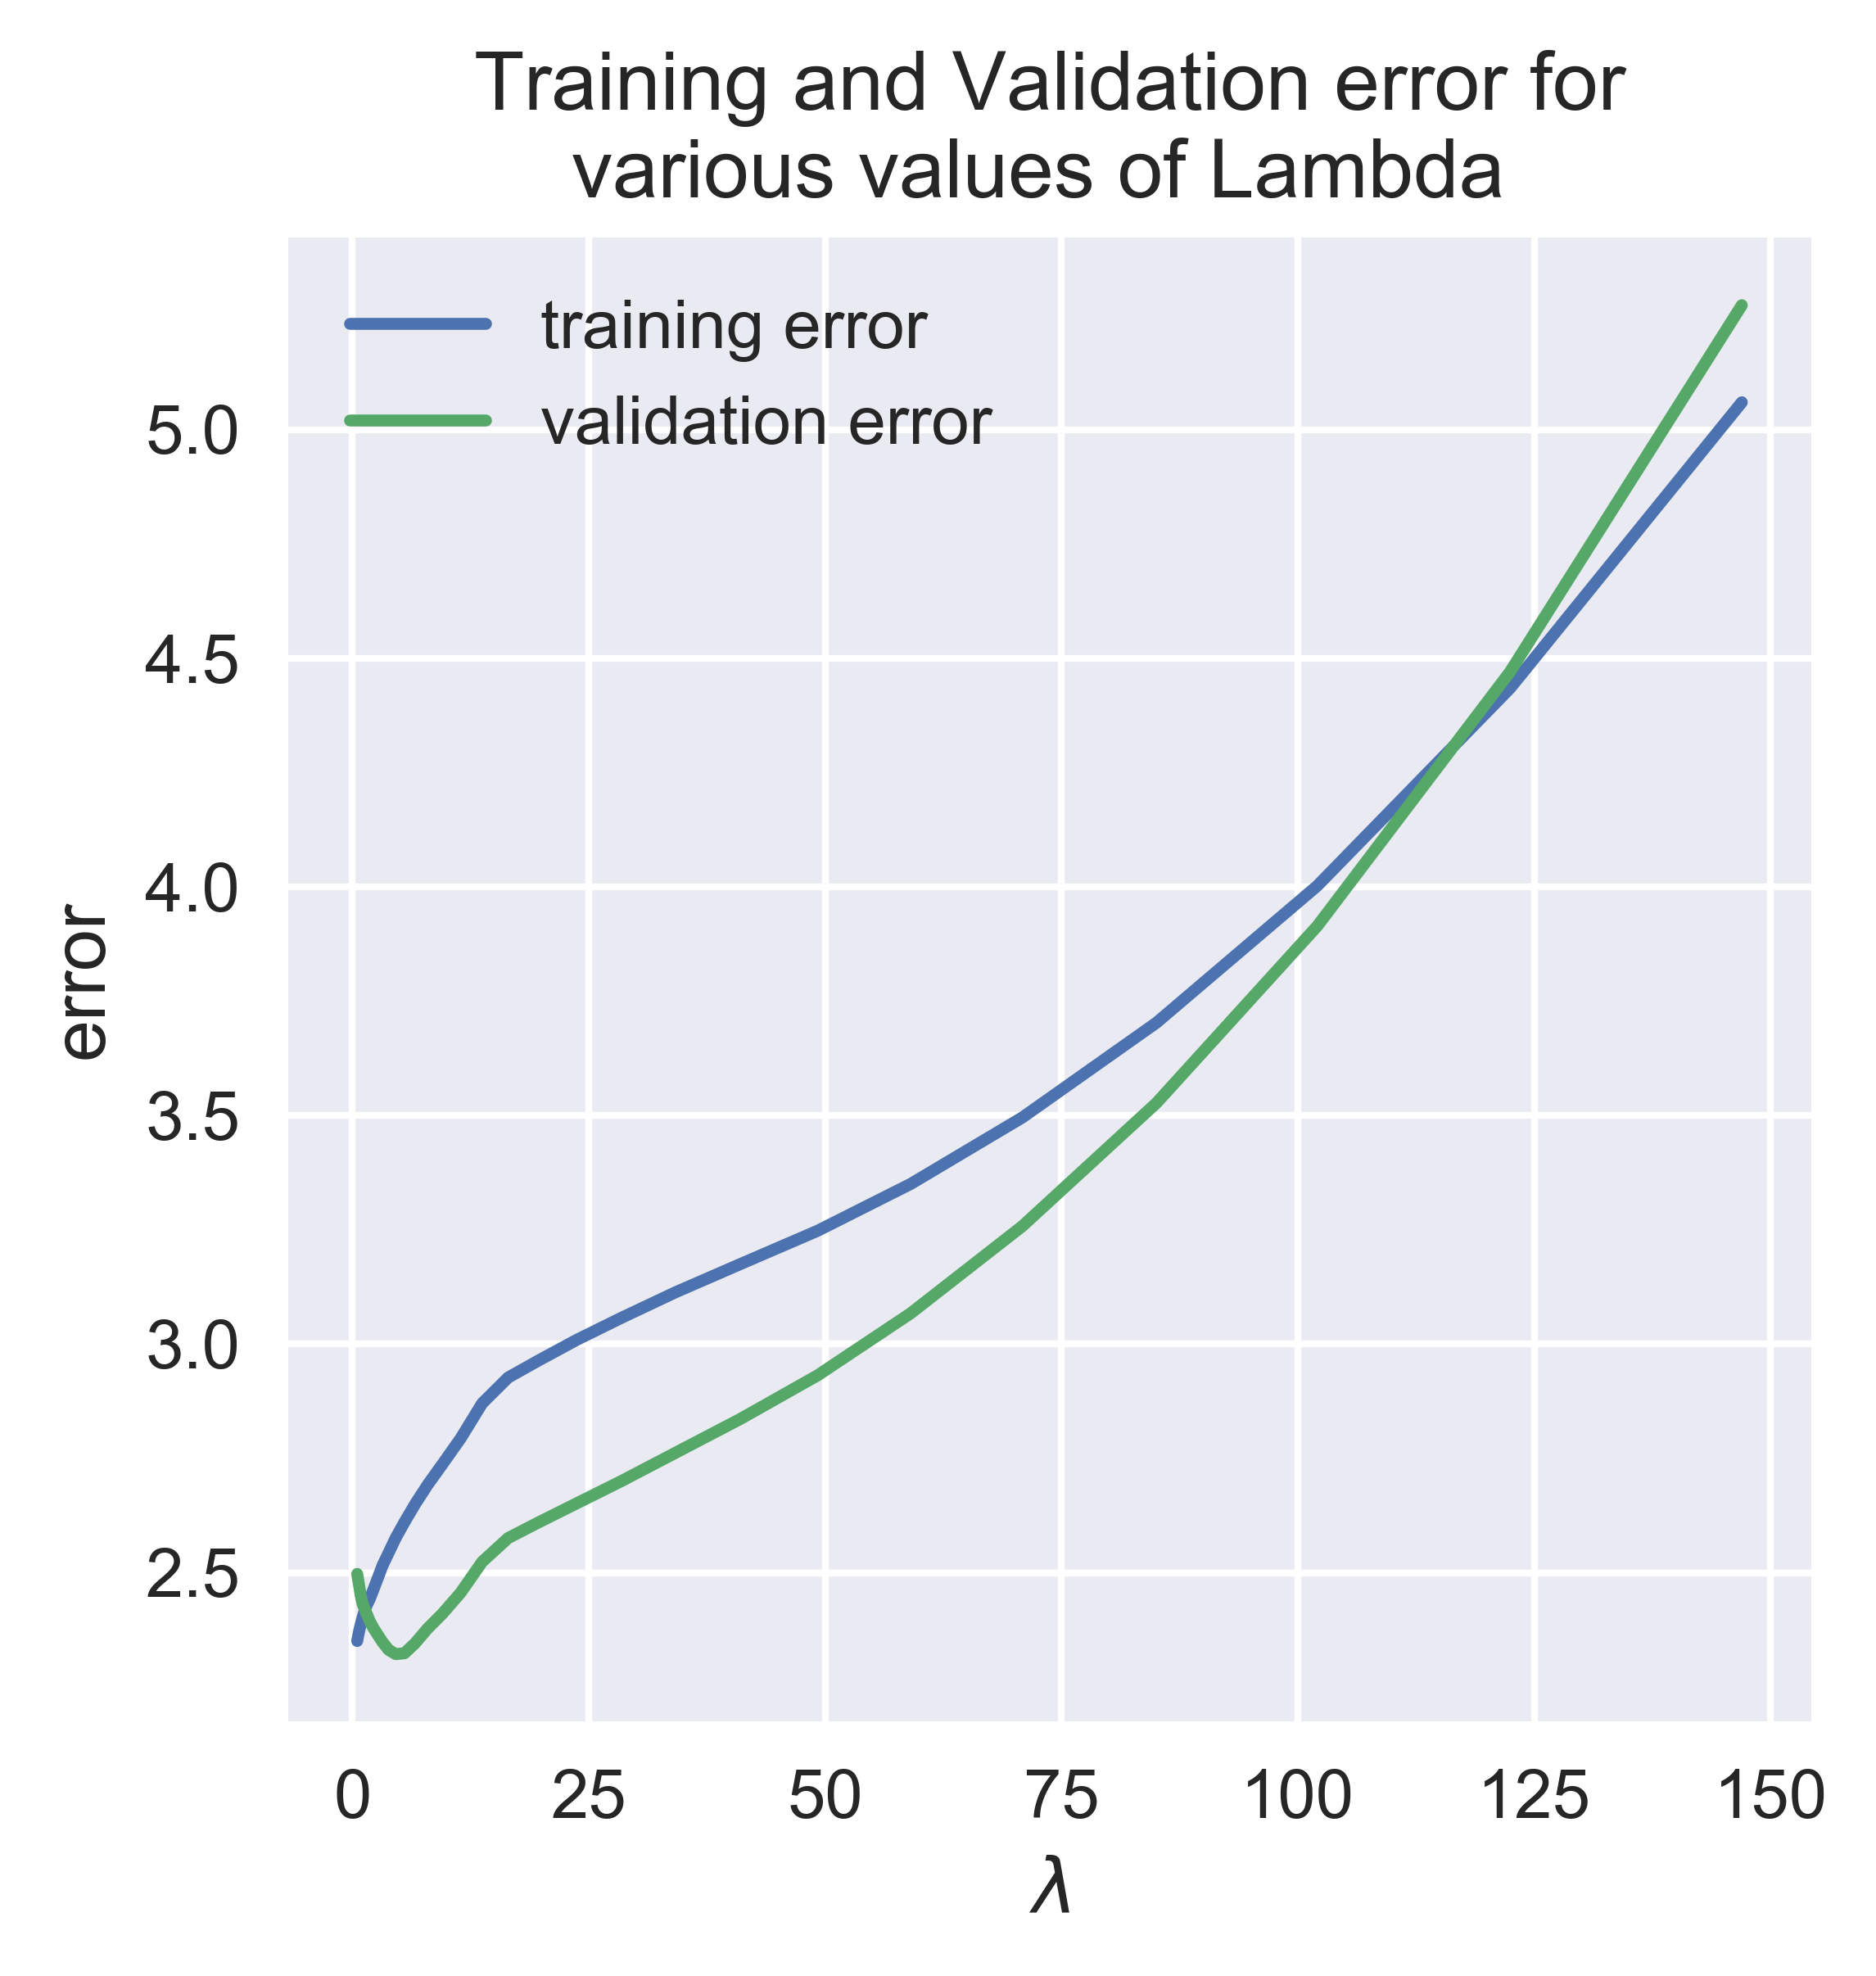

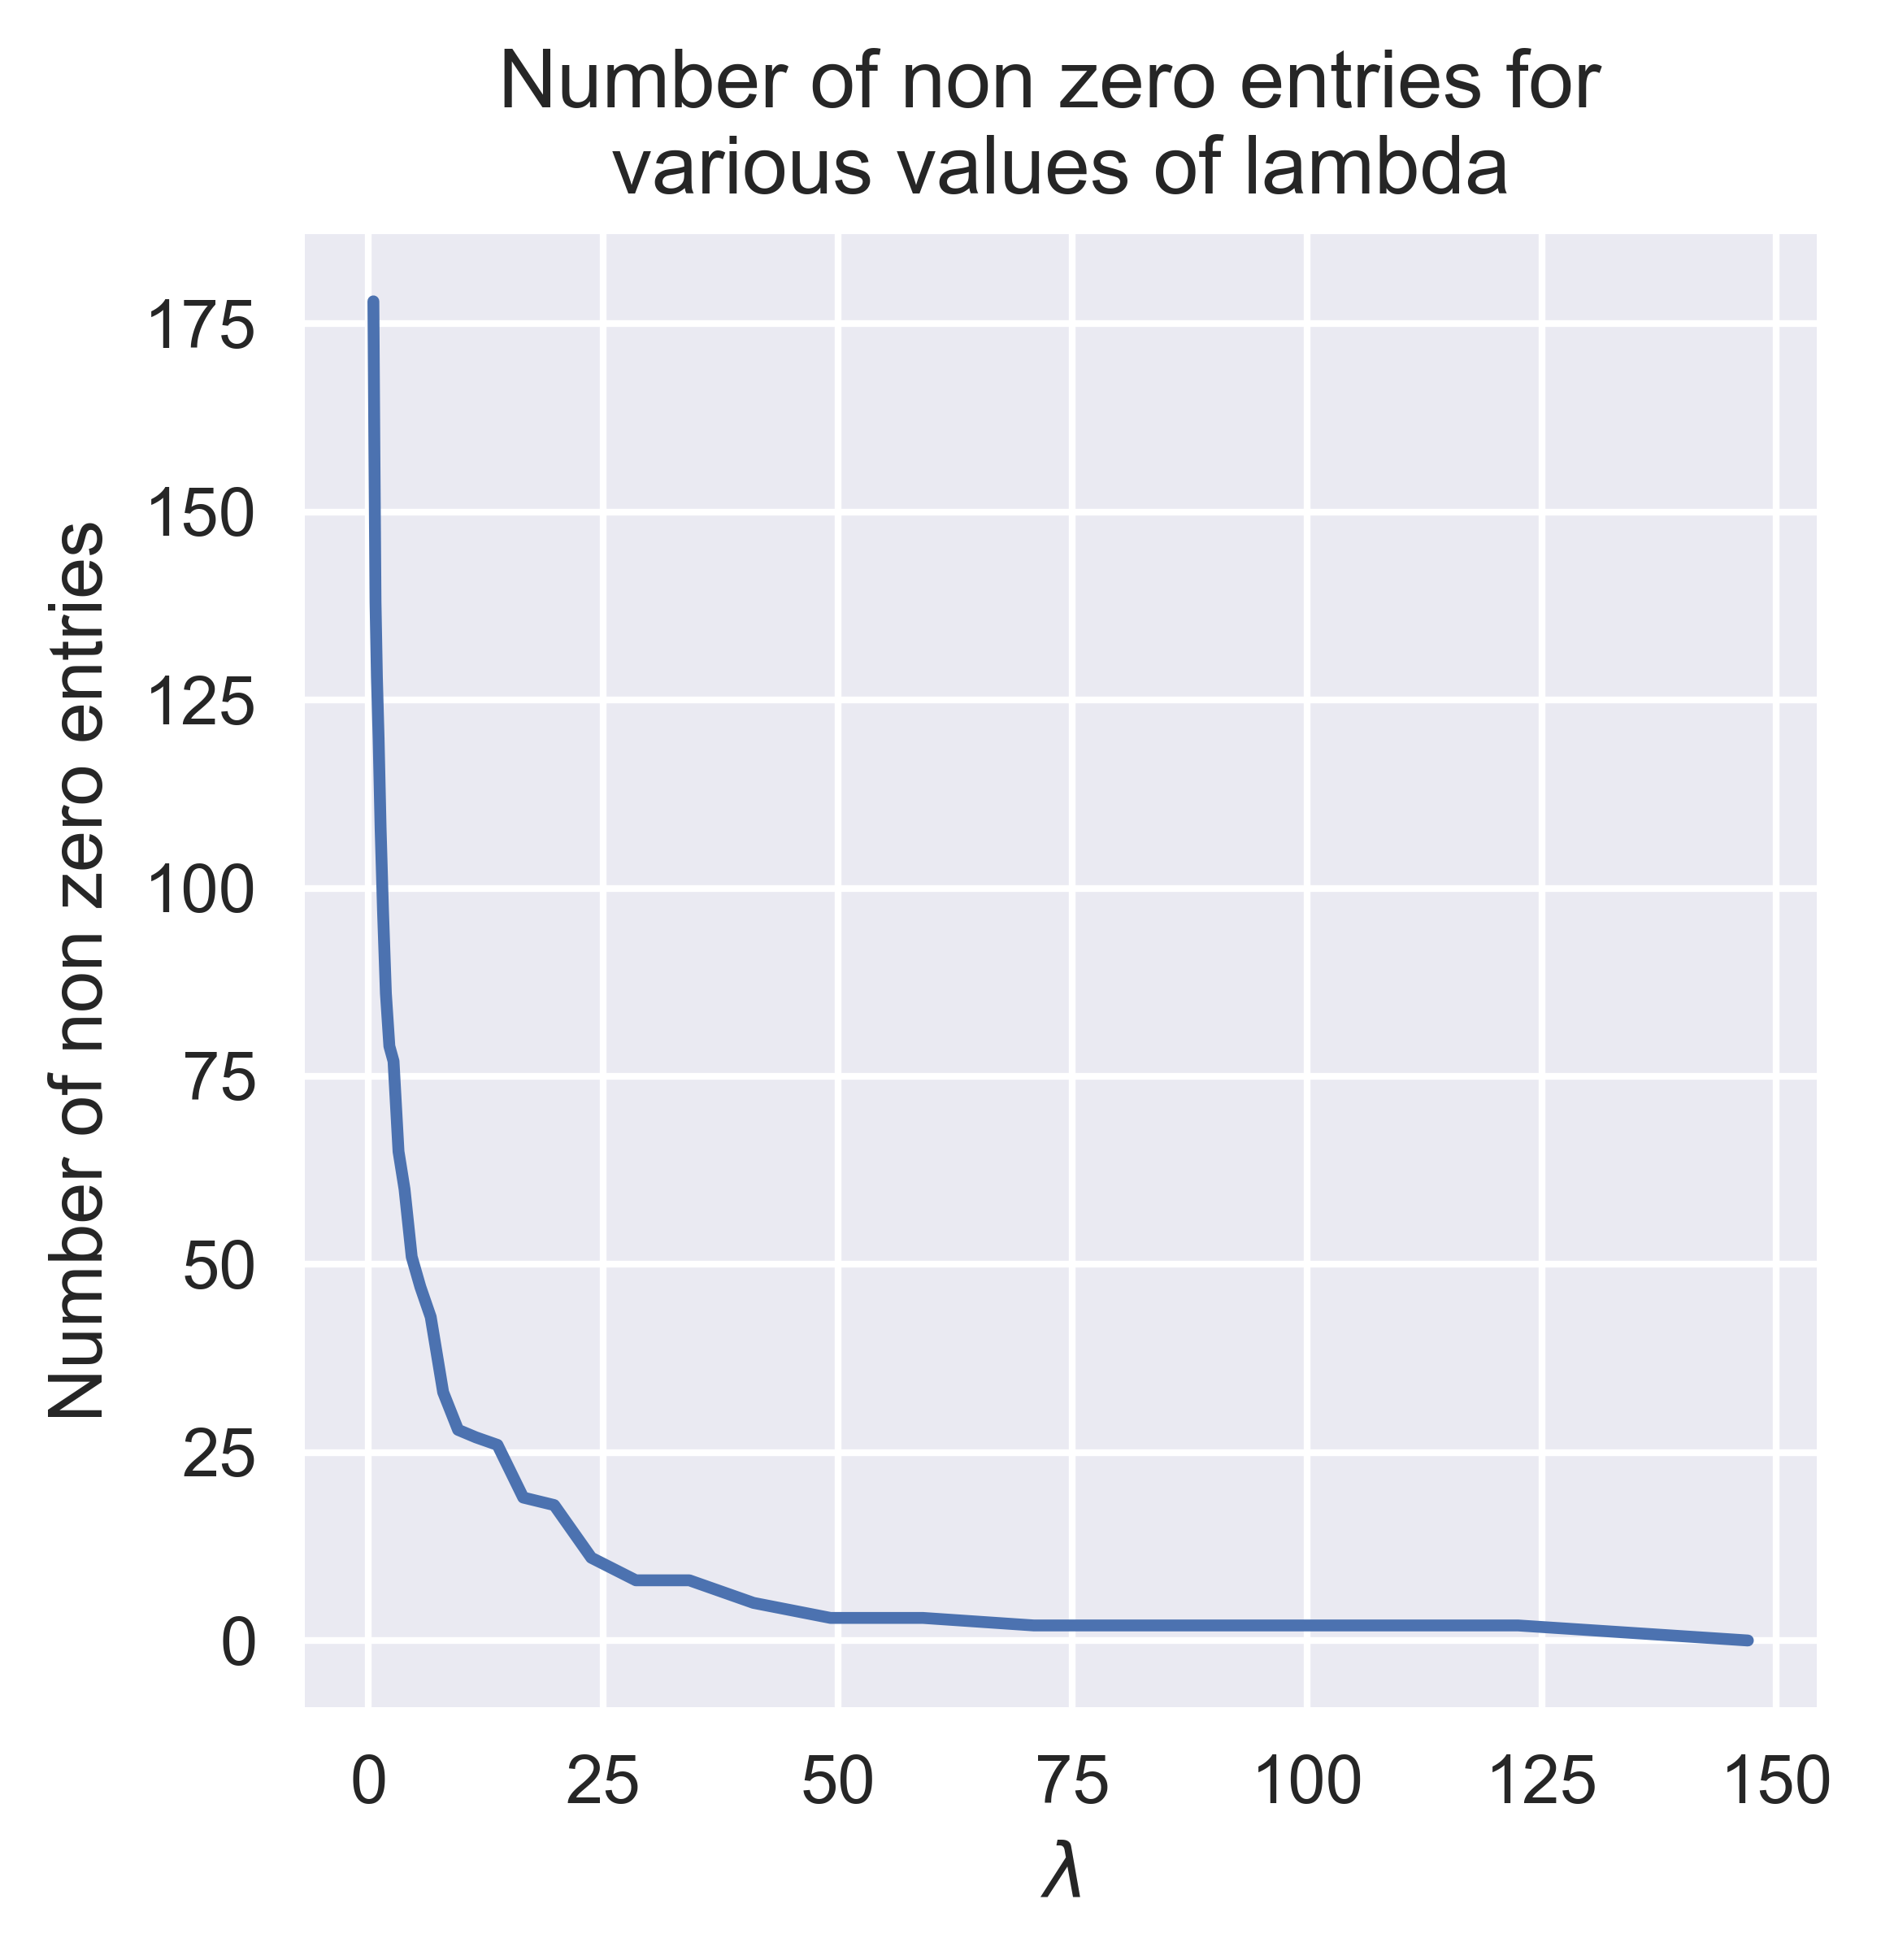

In [36]:
plot_valid_train(train_error_vec,valid_error_vec,num_non_zero_vec,lambda_vec)

### part b

In [37]:
valid_error_vec
lambda_vec[ind_valid_min]
np.shape(w_vec_array)
np.shape(w_best)
ind = np.argmin(w_best)
featureNamesArray[ind]

[5.2720652693806107,
 4.4709173177430586,
 3.9142047380868812,
 3.5272413328159495,
 3.2581648286737455,
 3.067561804315436,
 2.9317938504821126,
 2.836151915330281,
 2.7623772507211242,
 2.7008389897836871,
 2.6519023280701406,
 2.6110789831366659,
 2.5760046701495325,
 2.5240797723406749,
 2.4561484827961673,
 2.4108191574454283,
 2.3778141831254818,
 2.3456502713246263,
 2.3241092131488648,
 2.3221209735626815,
 2.3316828980074455,
 2.3484328587620613,
 2.3654492098517843,
 2.3796502257168655,
 2.3940041644210615,
 2.4093596299087521,
 2.4216189440325016,
 2.4331975141039694,
 2.4502342458529993,
 2.4694060831582245,
 2.4845359302230401,
 2.4975189292807083]

41.01277285328851

(12, 1000)

(1000,)

'ReviewDate*UserNumReviews'

In [54]:
# lambda optimal
ind_valid_min = np.array(np.argmin(valid_error_vec))
lambda_opt = lambda_vec[ind_valid_min]
w_vec_array = np.array(w_vec)
w_best = w_vec_array[ind_valid_min,:]

test_error = error_calc(test_d,test_l,w_best)
print('The test error is {:03.2f}'.format(test_error))


The test error is 4.22


### part c

In [42]:
featureNamesArray = np.array(featureNames)

In [89]:
inds_top10 = np.argpartition(np.abs(w_best), -10)[-10:]

top10_weight = np.around(w_best[inds_top10],decimals=2)

top10_feat = featureNamesArray[inds_top10]
zipped_top10 = list(zip(top10_feat,top10_weight))

print ('The top ten feaures and their weights are \n')
for i in np.arange(len(top10_feat)):
    print('Feature: {}, Weight {}'.format(top10_feat[i],top10_weight[i]))


The top ten feaures and their weights are 

Feature: sq(ReviewDate*UserNumReviews), Weight -9.1
Feature: sq(UserFunnyVotes*BusinessNumStars), Weight 9.33
Feature: sq(ReviewNumWords*UserNumReviews), Weight -10.44
Feature: log(ReviewNumCharacters*UserUsefulVotes), Weight 12.48
Feature: ReviewDate*UserNumReviews, Weight -25.59
Feature: sqrt(UserCoolVotes*BusinessNumStars), Weight 20.26
Feature: sqrt(ReviewNumCharacters*UserFunnyVotes), Weight 39.35
Feature: sqrt(UserFunnyVotes*InPhoenix), Weight 13.37
Feature: UserUsefulVotes*InScottsdale, Weight 15.37
Feature: sqrt(ReviewNumCharacters*UserCoolVotes), Weight 27.34


### scratch section

In [73]:
np.shape(zipped_top10)
zipped_top10
list(zipped_top10[:,1])

(10, 2)

array([['sq(ReviewDate*UserNumReviews)', '-9.09705750887'],
       ['sq(UserFunnyVotes*BusinessNumStars)', '9.33134671384'],
       ['sq(ReviewNumWords*UserNumReviews)', '-10.4364298919'],
       ['log(ReviewNumCharacters*UserUsefulVotes)', '12.4753092033'],
       ['ReviewDate*UserNumReviews', '-25.5886651502'],
       ['sqrt(UserCoolVotes*BusinessNumStars)', '20.2649877276'],
       ['sqrt(ReviewNumCharacters*UserFunnyVotes)', '39.3538939113'],
       ['sqrt(UserFunnyVotes*InPhoenix)', '13.3654992075'],
       ['UserUsefulVotes*InScottsdale', '15.3705287'],
       ['sqrt(ReviewNumCharacters*UserCoolVotes)', '27.3385575145']],
      dtype='<U40')

['-9.09705750887',
 '9.33134671384',
 '-10.4364298919',
 '12.4753092033',
 '-25.5886651502',
 '20.2649877276',
 '39.3538939113',
 '13.3654992075',
 '15.3705287',
 '27.3385575145']

In [81]:
?np.trunc